In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3309, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 3309 (delta 506), reused 439 (delta 374), pack-reused 2729 (from 1)
Receiving objects: 100% (3309/3309), 232.16 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (2556/2556), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.6 MB/s eta 0:00

In [2]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 992.5 kB/s eta 0:00:00


In [3]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

In [4]:
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
def objective(params) -> float:
  x = np.array(params)
  x = x*200e-6 - 100e-6


  snd = SND(9500)
  snd.mvr_t1_th1(x[0])
  snd.mvr_t1_th2(x[1])
  snd.mvr_t1_chi1(x[2])
  snd.mvr_t1_chi2(x[3])
  snd.mvr_t4_th1(x[4])
  snd.mvr_t4_th2(x[5])
  snd.mvr_t4_chi1(x[6])
  snd.mvr_t4_chi2(x[7])



  snd.propagate_delay()

  dh1 = snd.get_t1_dh_sum()
  dd = snd.get_dd_sum()
  dh4 = snd.get_t4_dh_sum()
  do = snd.get_do_sum()
  my_IP_sum = snd.get_IP_sum()
  my_intensity = dh1 + dd + dh4 + do + my_IP_sum

  do_centroid = snd.get_IP_r()

  #result=-my_intensity/60000
  result = do_centroid*1e7


  return result

In [22]:
ys = objective([0.5, 0.5,0.5, 0.5, 0.5, 0.5,0.5, 0.5])
print(ys)

0.2709020524382323


In [23]:
space = [(0.4, 0.6), (0.4, 0.6), (0.0, 1.0), (0.0, 1.0), (0.4, 0.6), (0.4, 0.6), (0.0, 1.0), (0.0, 1.0)]

[0.4890028560956601, 0.4887564119676216, 0.46743689085511664, 0.4677822565406491]
-0.9615791150188546


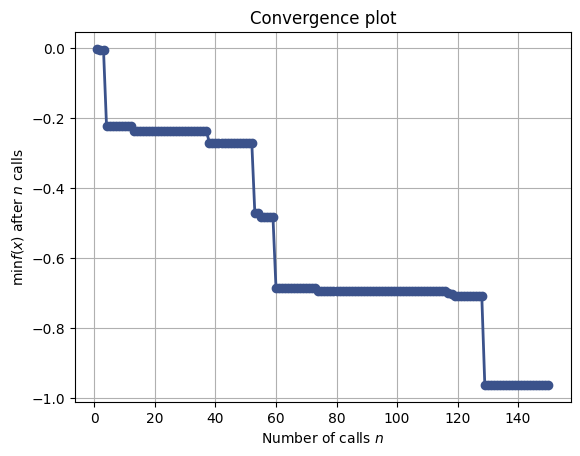

In [63]:
bo_gp = gp_minimize(objective,
                    space,
                    n_calls=150,
                    n_initial_points= 32,
                    initial_point_generator="sobol")
print(bo_gp.x)
print(bo_gp.fun)
plot_convergence(bo_gp);

In [24]:
def run_bo_chain(objective: callable=objective,
                 space: list=space,
                 n_calls: int=200,
                 n_initial_points:int= 32,
                 initial_point_generator: str="sobol"):
  bo_gp = gp_minimize(objective, space, n_calls=n_calls, n_initial_points=n_initial_points, initial_point_generator=initial_point_generator)
  print(bo_gp.x)
  print(bo_gp.fun)
  return bo_gp.func_vals

In [42]:
def run_rfbo_chain(objective: callable=objective,
                 space: list=space,
                 n_calls: int=200,
                 n_initial_points:int= 32,
                 initial_point_generator: str="sobol"):
  bo_rf = skopt.optimizer.forest_minimize(objective,
                                          space,
                                          n_calls=n_calls,
                                          n_initial_points=n_initial_points,
                                          initial_point_generator=initial_point_generator)
  return bo_rf.func_vals

In [47]:
def run_gbbo_chain(objective: callable=objective,
                 space: list=space,
                 n_calls: int=200,
                 n_initial_points:int= 32,
                 initial_point_generator: str="sobol"):
  bo_gbrt = skopt.optimizer.gbrt_minimize(objective,
                                          space,
                                          n_calls=n_calls,
                                          n_initial_points=n_initial_points,
                                          initial_point_generator=initial_point_generator)
  return bo_gbrt.func_vals

In [25]:
num_chains = 5
n_calls = 100
n_initial_points = 32

results = np.ones((num_chains, n_calls))

for i in range(num_chains):
  print(i)
  results[i,:] = run_bo_chain(objective, space, n_calls=n_calls, n_initial_points=n_initial_points)

0
[0.5607222297720522, 0.5484555715236686, 0.703282502757278, 0.09326366581318221, 0.5452653580311991, 0.5530612153918558, 0.2961436889239038, 0.8809259134608105]
61.28719475253166
1
[0.49047724832107475, 0.42346599539696006, 0.09382894164763496, 0.6894473757906668, 0.5205021084092557, 0.5900975935508597, 0.7720371805168704, 0.46197711748613185]
39.80491200503425
2
[0.517532061803716, 0.4835698995425787, 0.29923026526938706, 0.6651651585403914, 0.5666546411064153, 0.6, 0.06903642297318954, 0.9626883510210731]
7.93832102142774
3
[0.549059848768479, 0.490488661109763, 0.4973375367011088, 0.6586566348582498, 0.48542699283170654, 0.544764565421706, 0.2069150799971597, 0.6932944387827035]
57.06560054868053
4
[0.47679162326985053, 0.48778990019715623, 0.21214201429303628, 0.7809410211223542, 0.5998597609359748, 0.5876353983468464, 0.6110411290113312, 0.533981489202332]
16.972631671165203


Text(0, 0.5, 'BPE ($\\mu$m)')

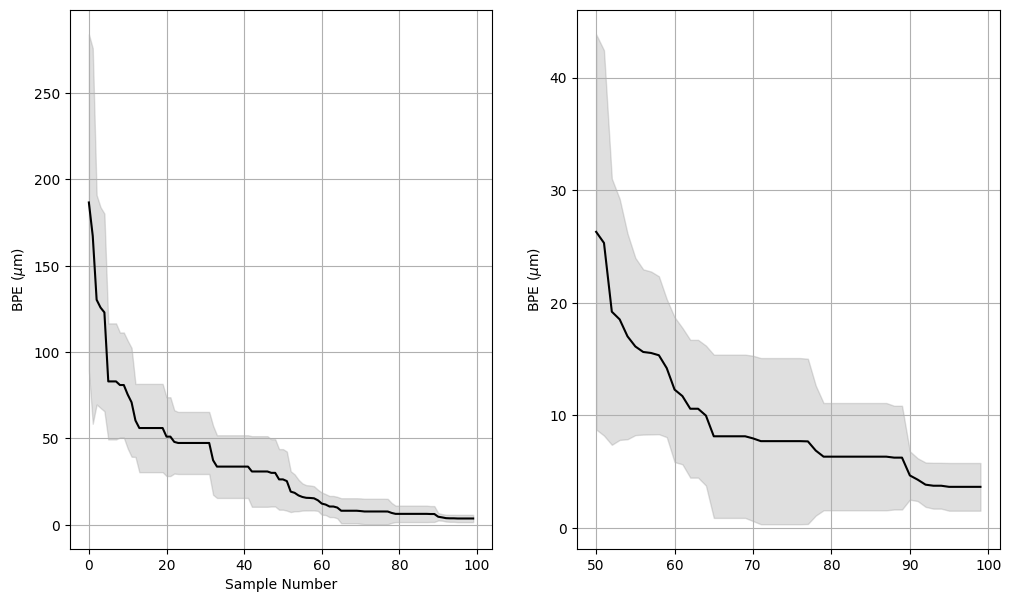

In [26]:
res = np.minimum.accumulate(results, axis=-1)
means = res.mean(axis=0)/10
stds = res.std(axis=0)/10

idx = np.arange(100)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
ax0.plot(idx, means,'k')
ax0.grid()
ax0.fill_between(idx, means-stds, means+stds, alpha=0.25, color='gray')
ax0.set_xlabel("Sample Number")
ax0.set_ylabel("BPE ($\mu$m)")

ax1.plot(idx[-50:], means[-50:],'k')
ax1.grid()
ax1.fill_between(idx[-50:], means[-50:]-stds[-50:], means[-50:]+stds[-50:], alpha=0.25, color='gray')
ax1.set_ylabel("BPE ($\mu$m)")

854.6329954956474


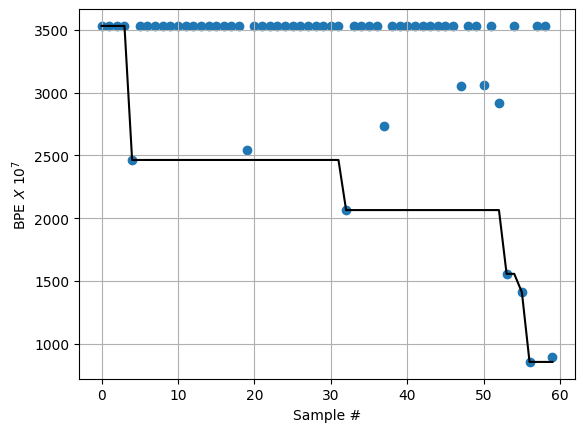

In [21]:
result = np.array(hist)
plt.plot(np.minimum.accumulate(result),'k')
plt.scatter(range(len(result)), result)
plt.xlabel("Sample #")
plt.ylabel("BPE $X~10^7$")
plt.grid()
print(np.min(result))

In [31]:
bo_gp = gp_minimize(objective, space, n_calls=200, random_state=42)
print(bo_gp.x)
print(bo_gp.fun)
plot_convergence(bo_gp);

In [55]:
print(bo_gp.x)
print(bo_gp.fun)

NameError: name 'bo_gp' is not defined

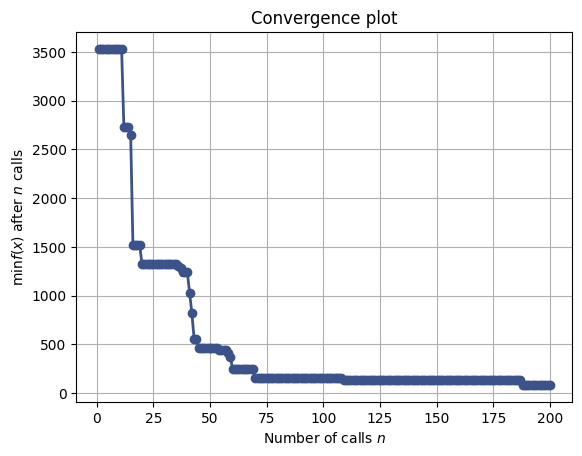

In [33]:
plot_convergence(bo_gp);

In [39]:
bo_rf = skopt.optimizer.forest_minimize(objective, space, n_calls=200)

In [40]:
print(bo_rf.x)
print(bo_rf.fun)

[0.5646251710386951, 0.4522348217901093, 0.24627735215837393, 0.3078110799831449, 0.5130594989049049, 0.6314905820383268, 0.5427111281726905, 0.8843139679930951]
156.6375935852587


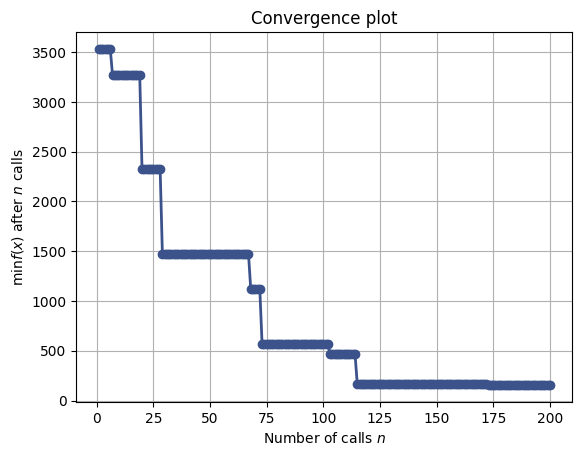

In [41]:
plot_convergence(bo_rf);

In [13]:
bo_gbrt = skopt.optimizer.gbrt_minimize(objective, space, n_calls=200)

In [14]:
print(bo_gbrt.x)
print(bo_gbrt.fun)

[0.4488015960721894, 0.6319848557545416, 0.23242257055896093, 0.5480856789977148, 0.42672957400133016, 0.29197848041590185, 0.8603523450186614, 0.3952125578605594]
720.5511385296218


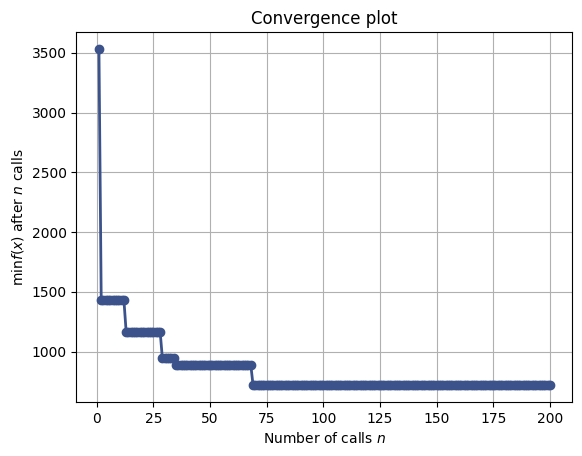

In [15]:
plot_convergence(bo_gbrt);